## Se connecter à une base de données SQL avec Python

### Qu’est-ce qu’un connecteur SQL ?

Un connecteur SQL permet à Python de communiquer avec une base de données SQL (MySQL, PostgreSQL, SQLite…).

Il existe plusieurs méthodes pour interagir avec les bases :

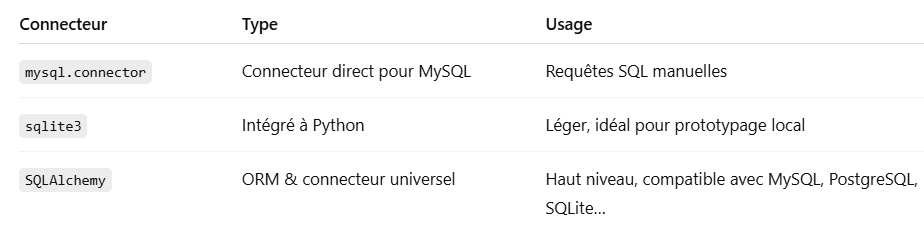


### Avec mysql.connector (MySQL)

✔️ Avantages :
Contrôle total sur les requêtes SQL

Intuitif pour les débutants SQL

🔽 Inconvénients :
Beaucoup de code "manuel"

Nécessite de gérer soi-même les transactions

In [1]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password=''
    )

    if connection.is_connected():
        cursor = connection.cursor()
        cursor.execute("CREATE DATABASE IF NOT EXISTS Books;")
        cursor.execute("USE Books;")
        print("Base créée et sélectionnée.")

except Error as e:
    print("Erreur MySQL :", e)
#finally:
    #if connection.is_connected():
        #cursor.close()
        #connection.close()


Base créée et sélectionnée.


### 2. Création de tables via requêtes SQL

In [2]:
create_Ratings_table = """
CREATE TABLE IF NOT EXISTS Ratings (
    rating_Id INT PRIMARY KEY AUTO_INCREMENT,
    score TINYINT NOT NULL CHECK (score >= 1 AND score <= 5)
);
"""
cursor.execute(create_Ratings_table)

In [3]:
create_Categories_table = """
CREATE TABLE IF NOT EXISTS Categories (
    category_Id INT PRIMARY KEY AUTO_INCREMENT,
    name VARCHAR(255)
);
"""
cursor.execute(create_Categories_table)

In [4]:
create_Books_table = """
CREATE TABLE IF NOT EXISTS Books (
    book_Id INT PRIMARY KEY AUTO_INCREMENT,
    title VARCHAR(255),
    price DECIMAL(10, 2),
    availability BOOLEAN,
    category_Id INT,
    rating_Id INT,
    FOREIGN KEY (category_Id) REFERENCES Categories(category_Id),
    FOREIGN KEY (rating_Id) REFERENCES Ratings(rating_Id)
);
"""
cursor.execute(create_Books_table)


In [16]:
if connection.is_connected():
        cursor.close()
        connection.close()

### Partie 2 : Insérer des données depuis un DataFrame (pandas)

In [5]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password=''
    )

    if connection.is_connected():
        cursor = connection.cursor()
        cursor.execute("CREATE DATABASE IF NOT EXISTS Books;")
        cursor.execute("USE Books;")
        print("Base créée et sélectionnée.")

except Error as e:
    print("Erreur MySQL :", e)

Base créée et sélectionnée.


In [20]:
import pandas as pd

# Création du dataframe # all_books.csv # books_by_category_with_titles.csv
df_Books = pd.read_csv('all_books.csv')

connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='books'
)

cursor = connection.cursor()

# Convertir la colonne 'availability' en booléen 1 ou 0 à la place de "In stock"
df_Books['availability'] = df_Books['availability'].str.contains("In stock")

for _, row in df_Books.iterrows():
    cursor.execute(
        "INSERT INTO Books (title, price, availability) VALUES (%s, %s, %s)",
        (row['title'], row['price'], row['availability'])
    )

connection.commit()


In [21]:
try:
    cursor = connection.cursor()
    
    # Requête pour lire tout le contenu de la table Books
    cursor.execute("SELECT * FROM Books limit 10;")
    
    # Récupérer les résultats
    rows = cursor.fetchall()
    
    print(" Contenu de la table Books :")
    for row in rows:
        print(row)

except Error as e:
    print(f"Erreur lors de la lecture : {e}")


 Contenu de la table Books :
(1, 'A Light in the Attic', Decimal('51.77'), 1, None, None)
(2, 'Tipping the Velvet', Decimal('53.74'), 1, None, None)
(3, 'Soumission', Decimal('50.10'), 1, None, None)
(4, 'Sharp Objects', Decimal('47.82'), 1, None, None)
(5, 'Sapiens: A Brief History of Humankind', Decimal('54.23'), 1, None, None)
(6, 'The Requiem Red', Decimal('22.65'), 1, None, None)
(7, 'The Dirty Little Secrets of Getting Your Dream Job', Decimal('33.34'), 1, None, None)
(8, 'The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull', Decimal('17.93'), 1, None, None)
(9, 'The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics', Decimal('22.60'), 1, None, None)
(10, 'The Black Maria', Decimal('52.15'), 1, None, None)


In [9]:
# Lecture de la table Books dans un DataFrame
df_BooksRead = pd.read_sql("SELECT * FROM Books;", con=connection)

# Affichage
df_BooksRead.head()

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_2504\2425033783.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_BooksRead = pd.read_sql("SELECT * FROM Books;", con=connection)


,book_Id,title,price,availability,category_Id,rating_Id
0,1,A Light in the Attic,51.77,1,None,None
1,2,Tipping the Velvet,53.74,1,None,None
2,3,Soumission,50.10,1,None,None
3,4,Sharp Objects,47.82,1,None,None
4,5,Sapiens: A Brief History of Humankind,54.23,1,None,None


###  Partie 3 : Avec SQLAlchemy (plus modulaire et puissant)

In [22]:
from sqlalchemy import create_engine
import pandas as pd
import sqlalchemy


# Connexion à la base MySQL
engine = create_engine("mysql+mysqlconnector://root:@localhost/books")

# DataFrame
df_Books = pd.read_csv('books_by_category_with_titles.csv')

# Insert data into the table, appending new rows
df_Books.to_sql('categories', con=engine, if_exists='append', index=False, 
                dtype={
                    "Category": sqlalchemy.String(length=255),
                    "Number of Books": sqlalchemy.Integer,
                    "Book Titles": sqlalchemy.Text
                })


# Déconnexion
#engine.dispose()


-1

In [24]:
from sqlalchemy import create_engine, text
import pandas as pd

# Connexion via SQLAlchemy
engine = create_engine("mysql+mysqlconnector://root:@localhost/books")

# Ouverture d’une connexion sécurisée
with engine.connect() as conn:
    
    #  Pour exécuter une requête manuelle (SELECT brut)
    result = conn.execute(text("SELECT * FROM Books limit 10"))
    rows = result.fetchall()
    for row in rows:
        print(row)

    


(1, 'A Light in the Attic', Decimal('51.77'), 1, None, None)
(2, 'Tipping the Velvet', Decimal('53.74'), 1, None, None)
(3, 'Soumission', Decimal('50.10'), 1, None, None)
(4, 'Sharp Objects', Decimal('47.82'), 1, None, None)
(5, 'Sapiens: A Brief History of Humankind', Decimal('54.23'), 1, None, None)
(6, 'The Requiem Red', Decimal('22.65'), 1, None, None)
(7, 'The Dirty Little Secrets of Getting Your Dream Job', Decimal('33.34'), 1, None, None)
(8, 'The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull', Decimal('17.93'), 1, None, None)
(9, 'The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics', Decimal('22.60'), 1, None, None)
(10, 'The Black Maria', Decimal('52.15'), 1, None, None)


In [25]:
#  Pour charger directement un DataFrame
with engine.connect() as conn:
    df_books2 = pd.read_sql(text("SELECT * FROM Books"), con=conn)

df_books2.head()

,book_Id,title,price,availability,category_Id,rating_Id
0,1,A Light in the Attic,51.77,1,None,None
1,2,Tipping the Velvet,53.74,1,None,None
2,3,Soumission,50.10,1,None,None
3,4,Sharp Objects,47.82,1,None,None
4,5,Sapiens: A Brief History of Humankind,54.23,1,None,None


Je vais remplacer les valeurs de la colonne 'rating' passer de str à int

In [31]:
# Load the data
df_Books = pd.read_csv('all_books.csv')

# Replace the rating values
df_Books['rating'] = df_Books['rating'].replace({
    'One': '1',
    'Two': '2',
    'Three': '3',
    'Four': '4',
    'Five': '5'
})

# Display the updated dataframe
df_Books.head()

,title,rating,price,availability
0,A Light in the Attic,3,51.77,In stock
1,Tipping the Velvet,1,53.74,In stock
2,Soumission,1,50.10,In stock
3,Sharp Objects,4,47.82,In stock
4,Sapiens: A Brief History of Humankind,5,54.23,In stock


Je vais mélanger les 2 df pour en faire un final

In [35]:
# Merge the DataFrames with df_books2 as the left DataFrame
df_final_books = pd.merge(df_books2, df_Books, on='title', how='left')

# Drop the duplicate columns, keeping the _x versions
df_final_books = df_final_books.drop(columns=['price_y', 'availability_y'])

# Rename the remaining columns to remove the _x suffix
df_final_books = df_final_books.rename(columns={'price_x': 'price', 'availability_x': 'availability'})

# Display the resulting DataFrame
df_final_books.head()

,book_Id,title,price,availability,category_Id,rating_Id,rating
0,1,A Light in the Attic,51.77,1,None,None,3
1,2,Tipping the Velvet,53.74,1,None,None,1
2,3,Soumission,50.10,1,None,None,1
3,4,Sharp Objects,47.82,1,None,None,4
4,5,Sapiens: A Brief History of Humankind,54.23,1,None,None,5


### Partie 4 : SQLite (local, sans serveur)

Créer une base SQLite et des tables

In [36]:
import sqlite3

connection = sqlite3.connect("database_books.db")

create_books_table = '''
CREATE TABLE IF NOT EXISTS Books (
    book_id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT,
    price REAL,
    availability BOOLEAN
);
'''
connection.execute(create_books_table)
connection.commit()


In [37]:
#Insérer des données depuis pandas

df.to_sql('Books', con=connection, if_exists='append', index=False)

2

In [38]:
df_books3 = pd.read_sql("SELECT * FROM Books", con=connection)

df_books3.head()

,book_id,title,price,availability
0,1,Book C,15.0,1
1,2,Book D,20.0,1
2,3,Book C,15.0,1
3,4,Book D,20.0,1
